In [41]:
import pandas as pd
import numpy as np
import csv
from scipy.stats import pearsonr
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
results_folder = 'Q:\\Personal\\Irina\\projects\\isttc\\results\\monkey\\'

csv_data_file_pfdl = results_folder + 'data_pfdl_fixon_1500ms_fixation_binned_50ms.csv'
with open(csv_data_file_pfdl, newline='') as f:
    reader = csv.reader(f)
    sua_list_pfdl = list(reader)
    
n_spike_trains_pfdl = len(sua_list_pfdl)
print('N spike_trains in PFdl fixON {}'.format(n_spike_trains_pfdl))

N spike_trains in PFdl fixON 33018


In [26]:
time_series = np.asarray(sua_list_pfdl[35][3:]).astype(int)
print('time_series {}, \n shape {}'.format(time_series, time_series.shape))

time_series [2 2 1 3 2 3 1 4 1 1 2 2 2 0 1 1 0 1 2 0 2 0 1 0 0 1 1 2 3 2], 
 shape (30,)


#### Calc asf

In [27]:
def autocorr_verbose(y, lag=2, verbose=True):
    if verbose:
        print('Calc for lag {}, input length {}'.format(lag, y.shape))
    y = np.array(y).copy()
    y_bar = np.mean(y)
    denominator = sum((y - y_bar) ** 2) 
    if verbose:
        print('y_bar = {}, denominator = {}'.format(y_bar, denominator))
    numerator_p1 = y[lag:] - y_bar
    numerator_p2 = y[:-lag] - y_bar 
    if verbose:
        print('shape numerator_p1 {}, numerator_p2 {}'.format(numerator_p1.shape, numerator_p2.shape))
    numerator = sum(numerator_p1 * numerator_p2) 
    acf_lag = numerator / denominator
    if verbose:
        print('acf_lag {}'.format(acf_lag))
    return acf_lag

def my_auto_corr_verbose(time_series, nlags=2, verbose=True):
    acf = [1] 
    for i in range(1, (nlags + 1)):
        acf.append(autocorr_verbose(time_series, lag=i, verbose=verbose)) 
    return np.array(acf)

Calc for lag 1, input length (30,)
y_bar = 1.4333333333333333, denominator = 31.36666666666668
shape numerator_p1 (29,), numerator_p2 (29,)
acf_lag 0.09709528869996456
Calc for lag 2, input length (30,)
y_bar = 1.4333333333333333, denominator = 31.36666666666668
shape numerator_p1 (28,), numerator_p2 (28,)
acf_lag 0.3557208643287281
Calc for lag 3, input length (30,)
y_bar = 1.4333333333333333, denominator = 31.36666666666668
shape numerator_p1 (27,), numerator_p2 (27,)
acf_lag 0.14038257173219967
Calc for lag 4, input length (30,)
y_bar = 1.4333333333333333, denominator = 31.36666666666668
shape numerator_p1 (26,), numerator_p2 (26,)
acf_lag 0.13014523556500165
Calc for lag 5, input length (30,)
y_bar = 1.4333333333333333, denominator = 31.36666666666668
shape numerator_p1 (25,), numerator_p2 (25,)
acf_lag 0.010449876018420106
Calc for lag 6, input length (30,)
y_bar = 1.4333333333333333, denominator = 31.36666666666668
shape numerator_p1 (24,), numerator_p2 (24,)
acf_lag -0.045483528

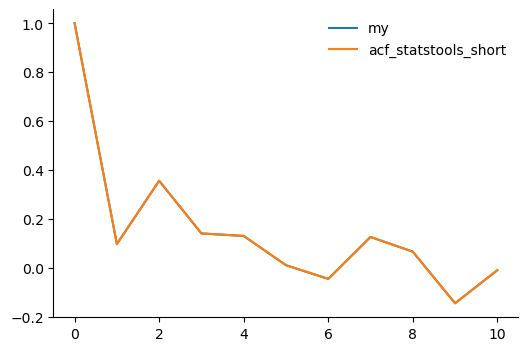

In [28]:
acf_my_short = my_auto_corr_verbose(time_series, nlags=10, verbose=True)
acf_statstools_short = acf(time_series,nlags=10)

print(f'my_auto_corr:\n{acf_my_short}\n\nstatstools acf:\n{acf_statstools_short}')

fig, axes = plt.subplots(1,1, figsize=(6,4))

t_lags = np.linspace(0,10,10+1)

axes.plot(t_lags, acf_my_short, label='my')
axes.plot(t_lags, acf_statstools_short, label='acf_statstools_short')

axes.legend(frameon=False)

sns.despine()

my_auto_corr:
[ 1.          0.09709529  0.35572086  0.14038257  0.13014524  0.01044988
 -0.04548353  0.12600071  0.06581651 -0.14527099 -0.00991853 -0.01590507
 -0.3130712  -0.08207581 -0.27509741 -0.05791711 -0.25518951 -0.03375841
 -0.15345377 -0.16369111 -0.10591569]

statstools acf:
[ 1.          0.09709529  0.35572086  0.14038257  0.13014524  0.01044988
 -0.04548353  0.12600071  0.06581651 -0.14527099 -0.00991853 -0.01590507
 -0.3130712  -0.08207581 -0.27509741 -0.05791711 -0.25518951 -0.03375841
 -0.15345377 -0.16369111 -0.10591569]


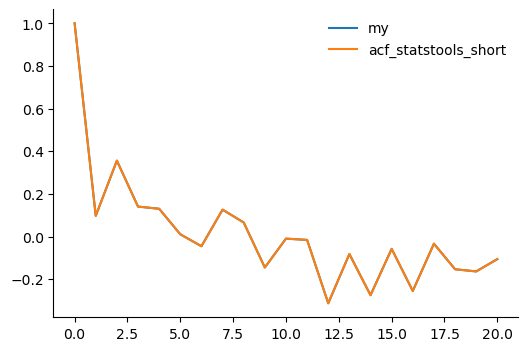

In [29]:
acf_my_short = my_auto_corr_verbose(time_series, nlags=20, verbose=False)
acf_statstools_short = acf(time_series,nlags=20)

print(f'my_auto_corr:\n{acf_my_short}\n\nstatstools acf:\n{acf_statstools_short}')

fig, axes = plt.subplots(1,1, figsize=(6,4))

t_lags = np.linspace(0,20,20+1)

axes.plot(t_lags, acf_my_short, label='my')
axes.plot(t_lags, acf_statstools_short, label='acf_statstools_short')

axes.legend(frameon=False)

sns.despine()

#### Calc acf as in Siegle

In [94]:
time_series_l = []
for sua_trial_ in sua_list_pfdl[:20]:
    print(sua_trial_)
    time_series_l.append(np.asarray(sua_trial_[3:23]).astype(int))

['0', '0', '0', '1', '1', '0', '0', '3', '0', '1', '2', '1', '1', '0', '0', '0', '0', '0', '2', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '3', '1', '0']
['0', '1', '0', '1', '1', '1', '1', '0', '1', '0', '0', '1', '1', '1', '0', '0', '0', '0', '1', '0', '2', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '2', '1']
['0', '2', '0', '1', '0', '0', '1', '0', '0', '0', '1', '2', '2', '2', '2', '1', '0', '0', '1', '0', '2', '0', '1', '1', '2', '1', '0', '1', '0', '1', '1', '0', '1']
['0', '3', '0', '0', '2', '2', '3', '1', '1', '4', '3', '2', '3', '1', '2', '1', '2', '1', '2', '2', '1', '2', '1', '3', '2', '1', '2', '1', '3', '3', '1', '1', '0']
['0', '4', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '1', '1', '2', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0']
['0', '5', '0', '0', '3', '1', '3', '0', '3', '2', '3', '3', '4', '2', '2', '1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '2', '1', '0', '0', '0', '0', '0', '1']
['0'

In [95]:
time_series_a = np.vstack(time_series_l)
time_series_a

array([[1, 1, 0, 0, 3, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 2, 2, 1, 0, 0, 1, 0, 2, 0, 1],
       [0, 2, 2, 3, 1, 1, 4, 3, 2, 3, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2],
       [0, 3, 1, 3, 0, 3, 2, 3, 3, 4, 2, 2, 1, 1, 1, 0, 1, 1, 0, 1],
       [1, 0, 1, 1, 2, 2, 3, 2, 1, 1, 0, 1, 2, 1, 1, 2, 3, 2, 0, 3],
       [4, 0, 0, 1, 2, 1, 1, 1, 0, 3, 1, 1, 2, 1, 4, 0, 1, 1, 1, 1],
       [0, 0, 0, 2, 2, 0, 1, 2, 4, 3, 2, 3, 1, 2, 2, 1, 2, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 3, 2, 2, 1, 2, 2, 1, 1, 1, 2, 3, 2, 2, 2, 1, 2, 2, 2, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 3, 0, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 0, 1, 2,

In [96]:
data = time_series_a
data.shape

(20, 20)

In [97]:
nbins = data.shape[1]
rsc_matrix = np.empty((nbins, nbins)) * 0

In [98]:
rsc_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [99]:
np.arange(nbins-1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [100]:
for i in np.arange(nbins-1):
    for j in np.arange(i+1, nbins): # filling i-th row
        r, p = pearsonr(data[:,i], data[:,j]) # todo here use sttc
        rsc_matrix[i, j] = r

In [101]:
rsc_matrix

array([[ 0.00000000e+00, -7.92166360e-02, -1.06576139e-01,
        -5.59454239e-02,  2.24280652e-01,  1.45861888e-02,
        -4.72825130e-02, -9.16290021e-02, -3.03345973e-01,
         1.36532997e-01, -1.67836272e-01, -1.96905961e-01,
         4.41706980e-01, -3.39774600e-02,  5.06747753e-01,
        -1.01932380e-01, -2.06661764e-01,  1.67501603e-02,
        -3.14939152e-02, -3.02674110e-01],
       [ 0.00000000e+00,  0.00000000e+00,  5.19501518e-01,
         6.81759840e-01, -8.40959915e-02,  4.86760494e-01,
         4.34360296e-01,  3.97560677e-01,  1.62488893e-01,
         3.07165447e-01,  1.57329194e-01,  2.95326447e-01,
         1.40141603e-01,  3.31243789e-01,  7.00035003e-02,
         2.67543060e-01,  1.08485490e-01,  6.90868096e-02,
         3.07031891e-01, -3.40470912e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.23333757e-01, -2.94165834e-01,  4.63563735e-01,
         5.00895256e-01,  1.78289495e-01, -1.31165167e-01,
        -2.64545330e-17,  8.4

In [102]:
np.fill_diagonal(rsc_matrix, 1)

<Axes: >

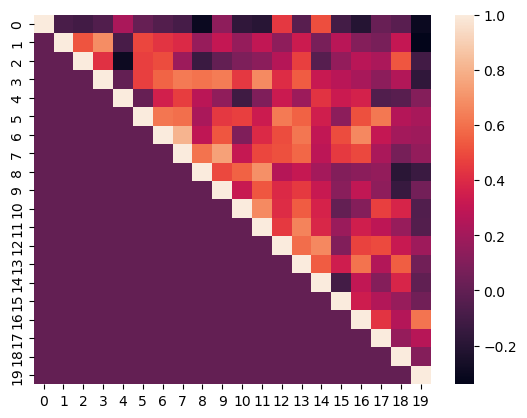

In [103]:
sns.heatmap(rsc_matrix)

In [104]:
T = np.zeros((nbins,))
for i in range(nbins):
    T[i] = np.nanmean(np.diag(rsc_matrix, k=i))

In [105]:
T

array([ 1.        ,  0.36296646,  0.38588515,  0.35353818,  0.34666735,
        0.31733815,  0.23089945,  0.25731956,  0.24789467,  0.20915815,
        0.22320308,  0.19936474,  0.29284579,  0.11344475,  0.22715124,
        0.11839977,  0.05373975,  0.07157328, -0.18598241, -0.30267411])

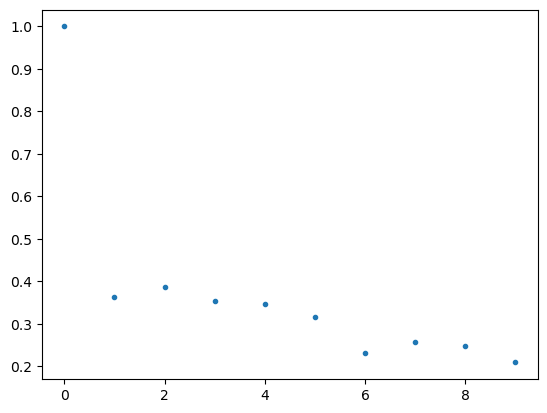

In [110]:
plt.plot(T[:10], '.')
##https://github.com/AllenInstitute/neuropixels_platform_paper/blob/master/Figure3/timescale_calculation.py